# 08 – Model Evaluation & Interpretability

This notebook focuses on understanding the model's performance and decision-making process.

**Goals:**
1.  **Confusion Matrix**: Visualize False Positives vs False Negatives.
2.  **PCA Analysis**: Visualize class separability in 2D.
3.  **SHAP Analysis**: Explain feature importance and individual predictions.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

c:\vs-code-projects\Loan\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
DATA_DIR = Path('../data')
train_path = DATA_DIR / 'train.csv'

print("Loading data...")
train_df = pd.read_csv(train_path)
print(f"Shape: {train_df.shape}")

Loading data...
Shape: (593994, 13)


In [3]:
def feature_engineering(df):
    df = df.copy()
    # Clipping (99th percentile)
    for col in ['annual_income', 'debt_to_income_ratio']:
        limit = df[col].quantile(0.99)
        df[col] = df[col].clip(upper=limit)
        
    df['loan_to_income'] = df['loan_amount'] / (df['annual_income'] + 1)
    df['monthly_debt'] = (df['annual_income'] / 12) * df['debt_to_income_ratio']
    df['interest_burden'] = df['loan_amount'] * (df['interest_rate'] / 100)
    return df

print("Applying feature engineering...")
train_df = feature_engineering(train_df)

target_col = 'loan_paid_back'
X = train_df.drop(columns=[target_col, 'id'])
y = train_df[target_col]

Applying feature engineering...


In [4]:
# Define Preprocessing Pipeline (Same as before)
log_features = ['annual_income']
numeric_features = ['debt_to_income_ratio', 'credit_score', 'loan_amount', 'interest_rate',
                    'loan_to_income', 'monthly_debt', 'interest_burden']
ordinal_features = ['grade_subgrade']
categorical_features = ['loan_purpose', 'gender', 'marital_status', 'education_level', 'employment_status']

log_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('log', FunctionTransformer(np.log1p, validate=False)),
    ('scaler', StandardScaler())
])

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

grades = sorted(X['grade_subgrade'].unique())
ordinal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OrdinalEncoder(categories=[grades], handle_unknown='use_encoded_value', unknown_value=-1))
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('log', log_transformer, log_features),
        ('num', numeric_transformer, numeric_features),
        ('ord', ordinal_transformer, ordinal_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

In [5]:
# Train a single XGBoost model for SHAP analysis (Stacking is hard to interpret directly)
# Use a subset for speed
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_subset = X_train.sample(n=20000, random_state=42)
y_subset = y_train.loc[X_subset.index]

print("Preprocessing data...")
X_processed = preprocessor.fit_transform(X_subset)
X_val_processed = preprocessor.transform(X_val.sample(n=5000, random_state=42))
y_val_subset = y_val.loc[X_val.sample(n=5000, random_state=42).index]

# Get feature names after preprocessing
feature_names = []
feature_names.extend(log_features)
feature_names.extend(numeric_features)
feature_names.extend(ordinal_features)
feature_names.extend(preprocessor.named_transformers_['cat']['encoder'].get_feature_names_out(categorical_features))

print("Training XGBoost for Interpretation...")
model = XGBClassifier(n_estimators=200, learning_rate=0.05, max_depth=5, random_state=42, eval_metric='auc')
model.fit(X_processed, y_subset)
print(f"Validation AUC: {roc_auc_score(y_val_subset, model.predict_proba(X_val_processed)[:, 1]):.4f}")

Preprocessing data...
Training XGBoost for Interpretation...
Validation AUC: 0.9174


## 1. Confusion Matrix

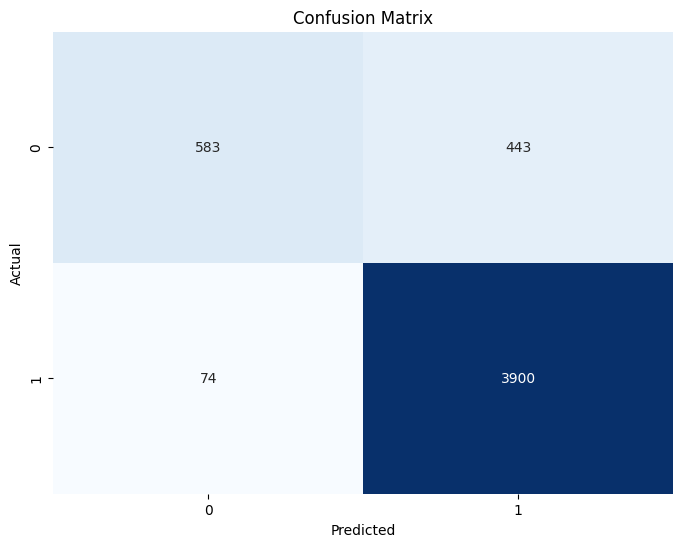

              precision    recall  f1-score   support

         0.0       0.89      0.57      0.69      1026
         1.0       0.90      0.98      0.94      3974

    accuracy                           0.90      5000
   macro avg       0.89      0.77      0.82      5000
weighted avg       0.90      0.90      0.89      5000



In [6]:
y_pred = model.predict(X_val_processed)
cm = confusion_matrix(y_val_subset, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_val_subset, y_pred))

## 2. PCA Analysis

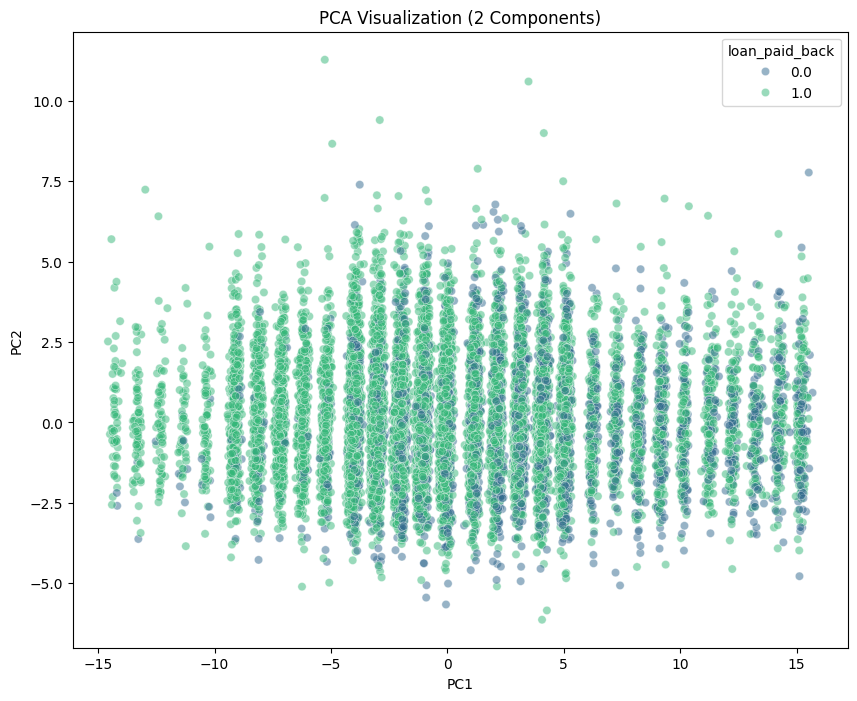

In [7]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_processed)

plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y_subset, alpha=0.5, palette='viridis')
plt.title('PCA Visualization (2 Components)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

## 3. SHAP Analysis

SHAP Summary Plot:


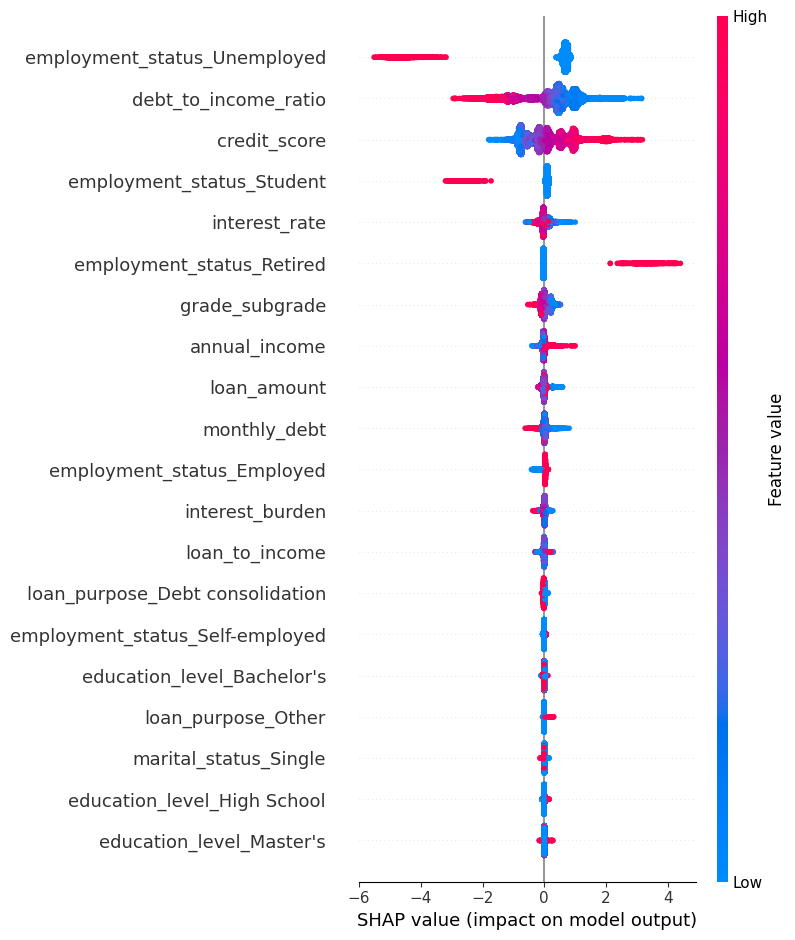

In [8]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_processed)

print("SHAP Summary Plot:")
shap.summary_plot(shap_values, X_processed, feature_names=feature_names)